# 01 - EDA
Proposito: cargar datos y generar estadisticos y graficos basicos.

Inputs:
- `config/project.json`
- CSV en `cfg["data_csv_path"]`

Outputs esperados:
- `outputs/figures/hist_var.png`
- `outputs/figures/qq_var.png`
- `outputs/figures/xy_scatter.png`


### 1. Project setup


In [1]:
import os, sys, json, glob
from IPython.display import Image, display

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir(PROJECT_ROOT)
else:
    PROJECT_ROOT = os.getcwd()
    os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CWD:", os.getcwd())

from src.preprocess import load_and_preprocess
from src.eda import basic_stats, plot_hist, plot_qq, plot_xy_scatter


PROJECT_ROOT: c:\Users\joelm\Documents\geostats
CWD: c:\Users\joelm\Documents\geostats


### 1.1 Diagnostics (kernel/venv)


In [2]:
import sys, os, importlib.util, subprocess

expected_venv = os.path.join(PROJECT_ROOT, ".venv")
print("sys.executable:", sys.executable)
print("sys.version:", sys.version)
print("find_spec('sklearn'):", importlib.util.find_spec("sklearn"))
print("expected .venv:", expected_venv)

try:
    result = subprocess.run(
        [sys.executable, "-m", "pip", "freeze"],
        capture_output=True,
        text=True,
        check=True,
    )
    lines = [line for line in result.stdout.splitlines() if "scikit-learn" in line.lower()]
    print("pip freeze (scikit-learn):", lines if lines else "not found")
except Exception as exc:
    print("pip freeze failed:", exc)

if expected_venv.lower() not in sys.executable.lower():
    print("WARNING: Kernel is not using the .venv interpreter.")
    print("Select kernel .venv in Jupyter: Kernel > Change Kernel > .venv (or python.exe inside .venv\\Scripts).")


sys.executable: c:\Users\joelm\Documents\geostats\.venv\Scripts\python.exe
sys.version: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:35:28) [MSC v.1944 64 bit (AMD64)]
find_spec('sklearn'): ModuleSpec(name='sklearn', loader=<_frozen_importlib_external.SourceFileLoader object at 0x0000027F8168F610>, origin='c:\\Users\\joelm\\Documents\\geostats\\.venv\\Lib\\site-packages\\sklearn\\__init__.py', submodule_search_locations=['c:\\Users\\joelm\\Documents\\geostats\\.venv\\Lib\\site-packages\\sklearn'])
expected .venv: c:\Users\joelm\Documents\geostats\.venv
pip freeze (scikit-learn): ['scikit-learn==1.8.0']


### 2. Load config


In [3]:
cfg_path = "config/project.json"
print("Config:", os.path.abspath(cfg_path))
with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)

print("Data CSV:", cfg["data_csv_path"])
mapping = {
    "x": cfg["columns"].get("x"),
    "y": cfg["columns"].get("y"),
    "z": cfg["columns"].get("z"),
    "var": cfg["columns"].get("variable_objetivo"),
    "domain": cfg["columns"].get("domain"),
}
print("Column mapping:", mapping)


Config: c:\Users\joelm\Documents\geostats\config\project.json
Data CSV: csv/Conminution.csv
Column mapping: {'x': 'X', 'y': 'Y', 'z': 'Z', 'var': 'Bwi_kWh_t', 'domain': 'Lito'}


### 3. Load data


In [4]:
df, df_raw, mapping = load_and_preprocess(cfg)

rows_before = len(df_raw)
rows_after = len(df)
removed_pct = 0.0 if rows_before == 0 else (rows_before - rows_after) * 100.0 / rows_before

print("Shape raw:", df_raw.shape, "clean:", df.shape)
print("Dtypes:\n", df.dtypes)
print("Rows removed (%):", f"{removed_pct:.2f}")
print("X range:", (df["x"].min(), df["x"].max()))
print("Y range:", (df["y"].min(), df["y"].max()))
if "z" in df.columns and df["z"].notna().any():
    print("Z range:", (df["z"].min(), df["z"].max()))
else:
    print("Z range: n/a")


Shape raw: (600, 12) clean: (600, 12)
Dtypes:
 x             float64
y             float64
z             float64
Hole ID           str
Samples_ID        str
Lote              str
domain            str
Minz              str
EM_new            str
EM                str
var           float64
Axb_SMC       float64
dtype: object
Rows removed (%): 0.00
X range: (np.float64(2363710.832), np.float64(2365405.149))
Y range: (np.float64(6485685.572631), np.float64(6487146.812069))
Z range: (np.float64(3104.889936), np.float64(3834.876096))


### 4. EDA


In [5]:
stats = basic_stats(df["var"])
print(stats)

os.makedirs("outputs/figures", exist_ok=True)
plot_hist(df["var"], "outputs/figures/hist_var.png")
plot_qq(df["var"], "outputs/figures/qq_var.png")
plot_xy_scatter(df, "x", "y", "var", "outputs/figures/xy_scatter.png", color_by="domain")


{'count': 600.0, 'mean': 13.876017316666667, 'std': 3.3420727873812917, 'min': 6.31005, 'p10': 10.21523, 'p50': 13.3933, 'p90': 17.91471, 'max': 36.7074}


### 4.1 Multivariable EDA


In [6]:
# Multivariable EDA (no new dependencies)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    HAS_SKLEARN = True
except Exception:
    HAS_SKLEARN = False

try:
    import ipywidgets as widgets
    from IPython.display import display as ipy_display
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False

# Build full dataframe for multivariable analysis
_df_full = df_raw.copy()
_nodata = cfg.get("nodata_values", [])
if _nodata:
    _df_full.replace(_nodata, np.nan, inplace=True)

# Optional category filters (fallback to fixed params if ipywidgets not available)
_filter_cols = {
    "domain": cfg["columns"].get("domain"),
    "lithology": cfg["columns"].get("lithology"),
    "alteration": cfg["columns"].get("alteration"),
}
_available_filters = {k: v for k, v in _filter_cols.items() if v and v in _df_full.columns}

# Fixed fallback selections
_domain_filter = "All"
_lithology_filter = "All"
_alteration_filter = "All"

if not _available_filters:
    print("No domain/lithology/alteration columns available for filtering.")


def _apply_filters(df_in, selections):
    df_out = df_in
    for key, col in _available_filters.items():
        sel = selections.get(key, "All")
        if sel != "All":
            df_out = df_out[df_out[col] == sel]
    return df_out


_default_filters = {
    "domain": _domain_filter,
    "lithology": _lithology_filter,
    "alteration": _alteration_filter,
}
_filtered_df = _apply_filters(_df_full, _default_filters)

# Select 3-8 numeric variables automatically (top variance)
_exclude = {cfg["columns"].get("x"), cfg["columns"].get("y"), cfg["columns"].get("z")}
_exclude.update([v for v in _filter_cols.values() if v])


def _build_numeric(df_in, exclude_cols):
    _numeric = {}
    for _col in df_in.columns:
        if _col in exclude_cols:
            continue
        _series = pd.to_numeric(df_in[_col], errors="coerce")
        if _series.notna().mean() >= 0.6:
            _numeric[_col] = _series
    return pd.DataFrame(_numeric)


_df_num = _build_numeric(_filtered_df, _exclude)

_var_col = cfg["columns"].get("variable_objetivo")

if _df_num.shape[1] < 2:
    print("Not enough non-coordinate numeric variables; including coordinates for multivariable EDA.")
    _exclude_coords = {v for v in _filter_cols.values() if v}
    _df_num = _build_numeric(_filtered_df, _exclude_coords)

if _df_num.shape[1] < 2:
    print("Not enough numeric variables for multivariable EDA.")
else:
    _vars_by_var = _df_num.var(ddof=1).sort_values(ascending=False)
    _selected = list(_vars_by_var.head(8).index)
    if _var_col in _df_num.columns and _var_col not in _selected:
        _selected.insert(0, _var_col)
        _selected = _selected[:8]
    if len(_selected) < 3 and len(_vars_by_var) >= 3:
        _selected = list(_vars_by_var.index[:3])

    _df_sel = _df_num[_selected]

    os.makedirs("outputs/figures", exist_ok=True)

    # Correlation heatmap (matplotlib only)
    _corr = _df_sel.corr()
    plt.figure(figsize=(6, 5))
    im = plt.imshow(_corr, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(_corr.columns)), _corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(_corr.index)), _corr.index)
    for i in range(len(_corr.index)):
        for j in range(len(_corr.columns)):
            val = _corr.iloc[i, j]
            if pd.notna(val):
                plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color="black")
    plt.tight_layout()
    plt.savefig("outputs/figures/corr_heatmap.png", dpi=150)
    plt.close()

    # PCA (optional, uses sklearn)
    if HAS_SKLEARN:
        _df_pca = _df_sel.dropna()
        if _df_pca.shape[1] >= 2 and _df_pca.shape[0] >= 2:
            _X = StandardScaler().fit_transform(_df_pca.values)
            _pca = PCA(n_components=min(_df_pca.shape[1], 5))
            _scores = _pca.fit_transform(_X)

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, len(_pca.explained_variance_ratio_) + 1), _pca.explained_variance_ratio_, marker="o")
            plt.xlabel("PC")
            plt.ylabel("Explained variance ratio")
            plt.tight_layout()
            plt.savefig("outputs/figures/pca_scree.png", dpi=150)
            plt.close()

            if _scores.shape[1] >= 2:
                plt.figure(figsize=(6, 5))
                plt.scatter(_scores[:, 0], _scores[:, 1], s=12, alpha=0.35)
                _max_score = float(np.max(np.abs(_scores[:, :2]))) if _scores.size else 1.0
                _loadings = _pca.components_.T[:, :2]
                for i, col in enumerate(_df_pca.columns):
                    plt.arrow(0, 0, _loadings[i, 0] * _max_score, _loadings[i, 1] * _max_score,
                              color="red", alpha=0.5, head_width=0.04 * _max_score)
                    plt.text(_loadings[i, 0] * _max_score * 1.1, _loadings[i, 1] * _max_score * 1.1,
                             col, color="red", fontsize=8)
                plt.xlabel("PC1")
                plt.ylabel("PC2")
                plt.tight_layout()
                plt.savefig("outputs/figures/pca_biplot.png", dpi=150)
                plt.close()
        else:
            print("PCA skipped: not enough rows/variables after filtering.")
    else:
        print("PCA skipped: sklearn not available.")

    # Scatter pair (selectable x/y)
    def _plot_pair(xvar, yvar, outpath=None):
        _data = _df_sel[[xvar, yvar]].dropna()
        plt.figure(figsize=(5, 5))
        plt.scatter(_data[xvar], _data[yvar], s=15, alpha=0.4)
        plt.xlabel(xvar)
        plt.ylabel(yvar)
        plt.tight_layout()
        if outpath:
            plt.savefig(outpath, dpi=150)
        plt.close()

    _pair_default = _selected[:2]
    if len(_pair_default) >= 2:
        _plot_pair(_pair_default[0], _pair_default[1], "outputs/figures/scatter_pair.png")

    if HAS_WIDGETS:
        _x_dd = widgets.Dropdown(options=_selected, value=_pair_default[0], description="X")
        _y_dd = widgets.Dropdown(options=_selected, value=_pair_default[1], description="Y")
        def _pair_view(xvar, yvar):
            _plot_pair(xvar, yvar, outpath=None)
            plt.show()
        ipy_display(_x_dd, _y_dd)
        widgets.interact(_pair_view, xvar=_x_dd, yvar=_y_dd)
    else:
        print("ipywidgets not available: using default scatter pair.")

# Optional interactive filter note
if HAS_WIDGETS and _available_filters:
    print("Tip: set _domain_filter/_lithology_filter/_alteration_filter and re-run to filter outputs.")


Dropdown(description='X', options=('Axb_SMC', 'Bwi_kWh_t'), value='Axb_SMC')

Dropdown(description='Y', index=1, options=('Axb_SMC', 'Bwi_kWh_t'), value='Bwi_kWh_t')

interactive(children=(Dropdown(description='X', options=('Axb_SMC', 'Bwi_kWh_t'), value='Axb_SMC'), Dropdown(d…

Tip: set _domain_filter/_lithology_filter/_alteration_filter and re-run to filter outputs.


### 5. Artifacts generated


Figures: ['c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\hist_var.png', 'c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\qq_var.png', 'c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\xy_scatter.png', 'c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\corr_heatmap.png', 'c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\pca_scree.png', 'c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\pca_biplot.png', 'c:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\scatter_pair.png']
Tables: []
Models: []


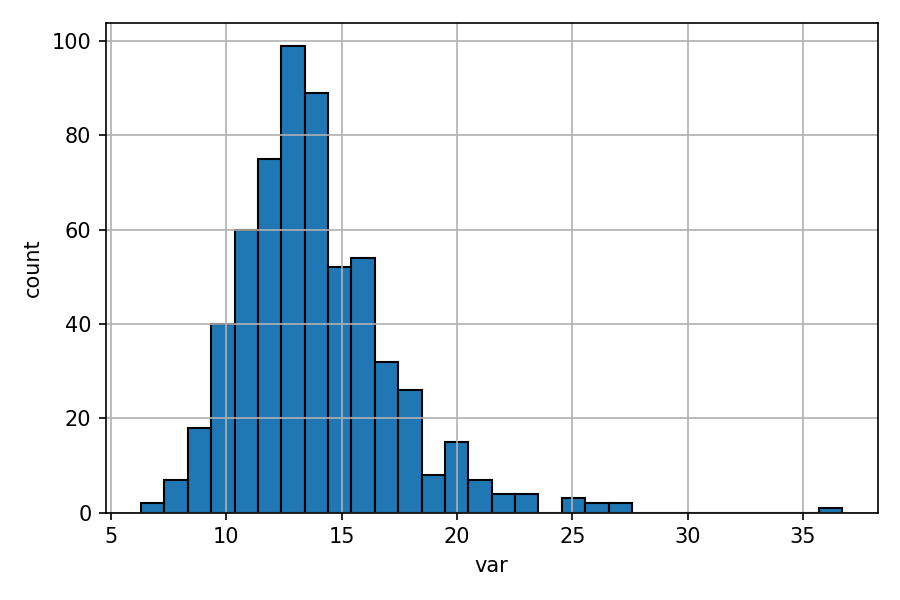

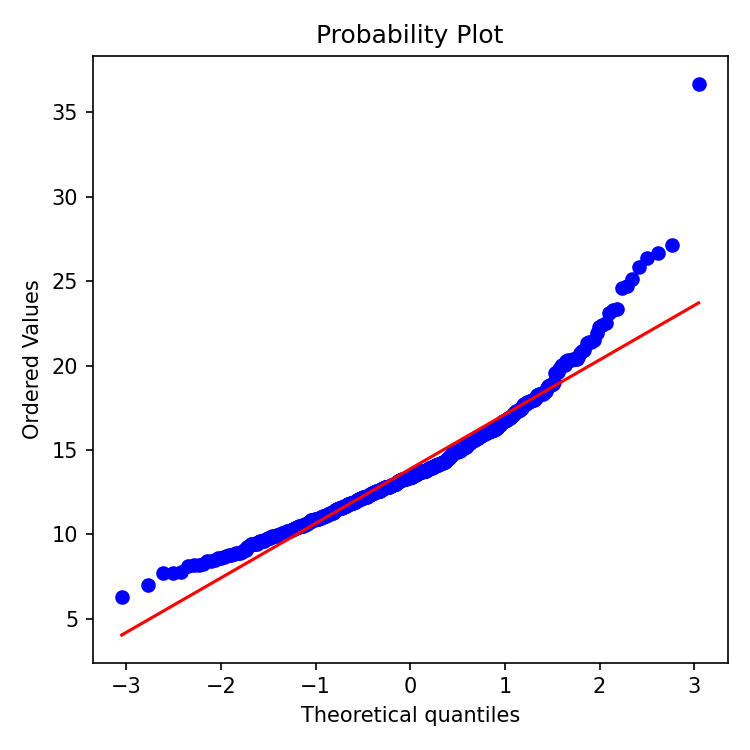

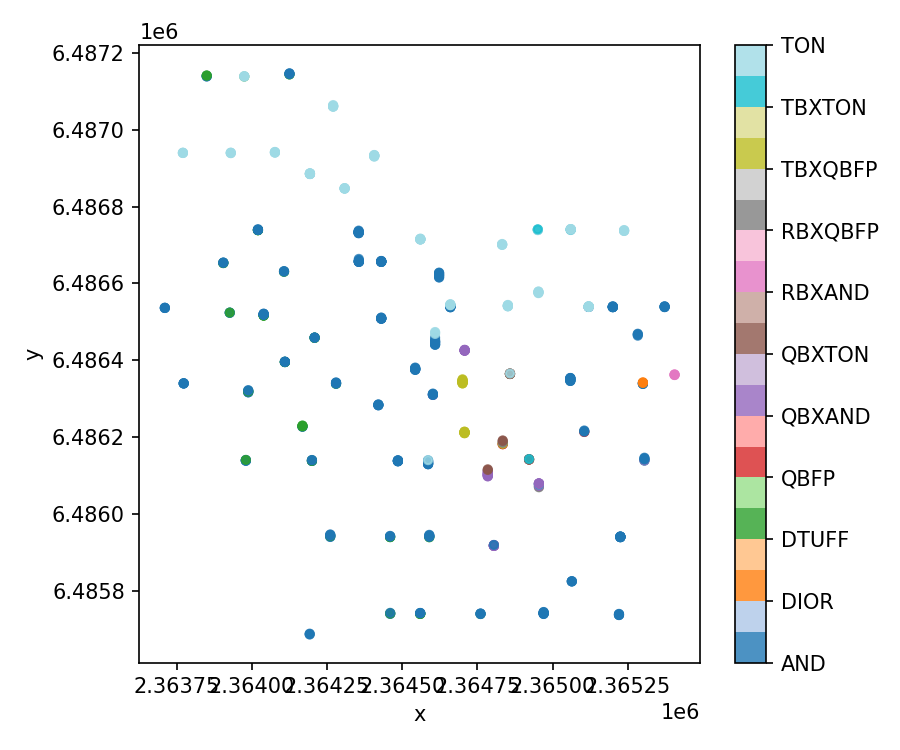

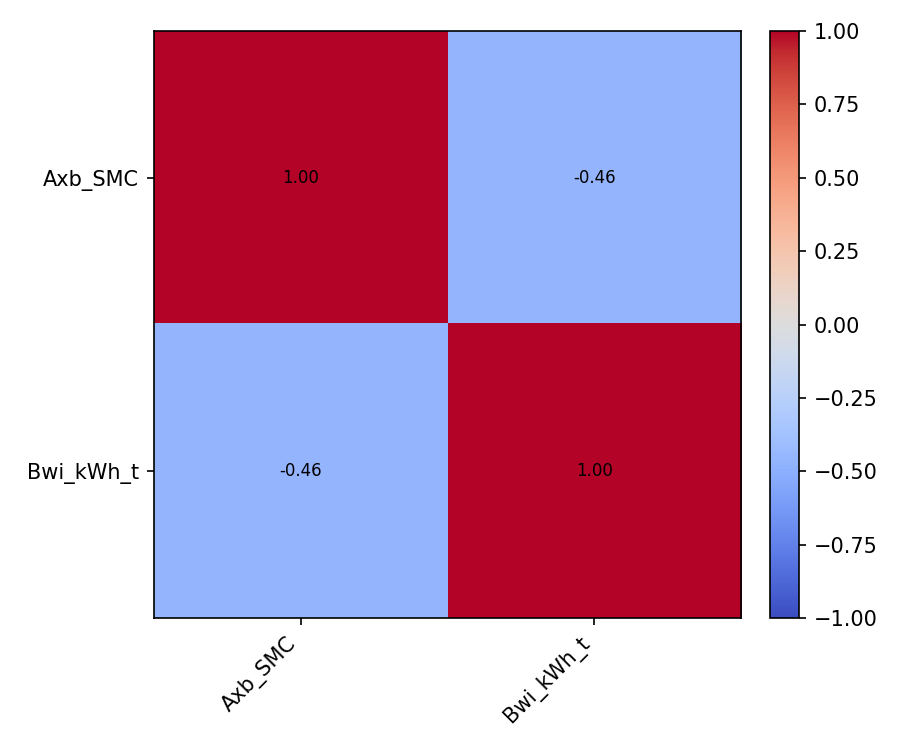

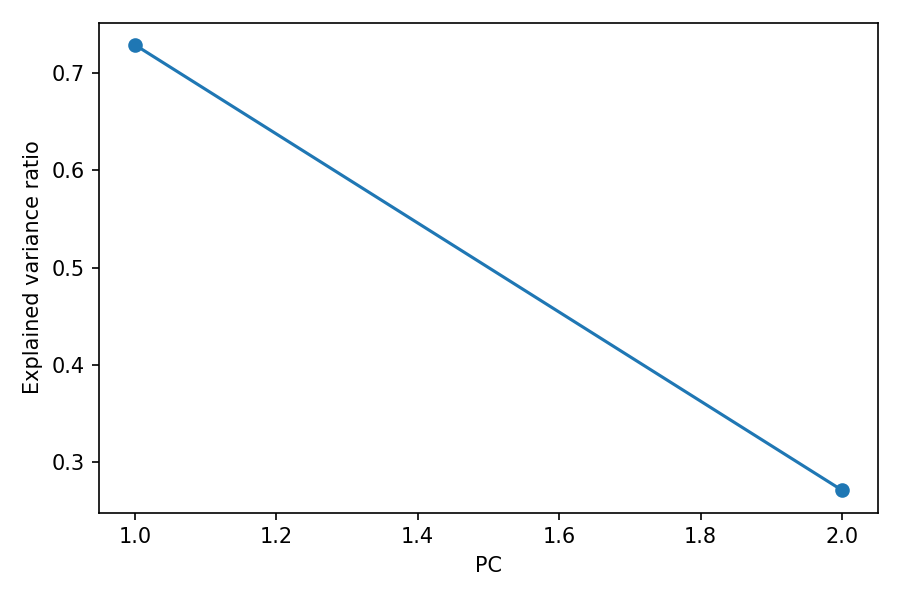

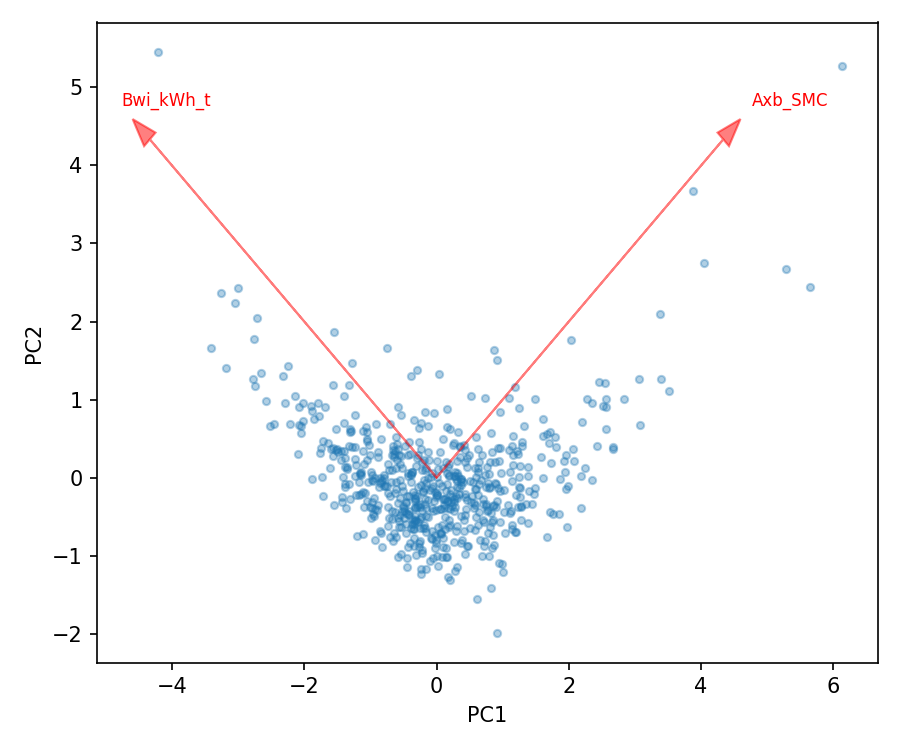

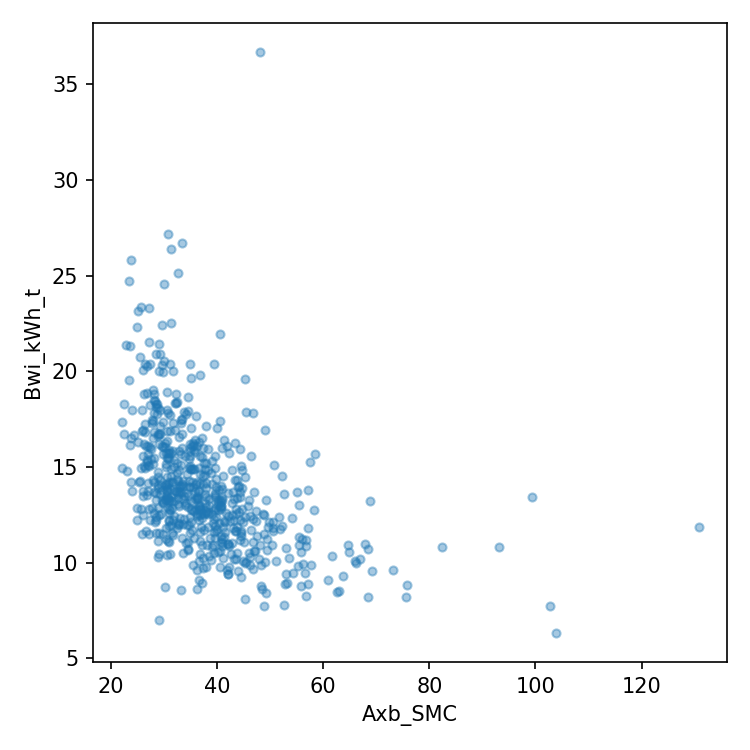

In [7]:
expected_figures = ['outputs/figures/hist_var.png', 'outputs/figures/qq_var.png', 'outputs/figures/xy_scatter.png', 'outputs/figures/corr_heatmap.png', 'outputs/figures/pca_scree.png', 'outputs/figures/pca_biplot.png', 'outputs/figures/scatter_pair.png']
expected_tables = []
expected_models = []

def _existing(paths):
    return [p for p in paths if os.path.exists(p)]

figure_paths = _existing(expected_figures)
table_paths = _existing(expected_tables)
model_paths = _existing(expected_models)

print("Figures:", [os.path.abspath(p) for p in figure_paths])
print("Tables:", [os.path.abspath(p) for p in table_paths])
print("Models:", [os.path.abspath(p) for p in model_paths])

for p in figure_paths:
    display(Image(filename=p))
